## Project goals

The dataset that I will be wrangling, analyzing and visualizing below is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. After gathering all data, I will assess them visually and programmatically for quality and tidiness issues. Detect and document at least **eight (8)** quality issues and **two (2)** tidiness issues. Store the clean DataFrame(s) in a CSV file with the main one named twitter_archive_master.csv. Additionally, the cleaned data will be stored in a SQLite database called twitter_archive_master.db. Finally, I will analyze and visualize the wrangled data the Jupyter Notebook. Three (3) insights and visualizations will be produced.

## Gather

### (0) Load all necessary packages

In [1]:
import os
import io
import re
import json
import tweepy
import requests
import datetime

import numpy as np
import pandas as pd
import sqlalchemy as db
import matplotlib.pyplot as plt

from tweepy import OAuthHandler
from bs4 import BeautifulSoup

### (1) Load .csv file provided by Udacity

The twitter-archive-enhanced.csv file was provided by Udacity, I will read it into a dataframe called df1 using pandas' read_csv() function.

In [2]:
df1 = pd.read_csv('twitter-archive-enhanced.csv')

### (2) Download .tsv file provided by Udacity
A url to the image-predictions.tsv file was provided by Udacity. I will use the get() function from the requests-package to retrieve the data. We need to make sure that we're decoding the binary using the correct encoding. Ultimately, I will read the data into a dataframe called df2 using pandas' read_csv() function and will specify tabs as separators since this is a .tsv file.

In [3]:
# download tsv-file containing image predictions
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [4]:
# retrieve encoding that was used
response.encoding

'utf-8'

In [5]:
df2 = pd.read_csv(io.StringIO(response.content.decode('utf-8')), sep='\t')

### (3) Retrieve tweets through twitter's API
I will retrieve information associated with every tweet listed in df1 through Twitter's API using the tweepy package. The data will be stored in tweet_json.txt as one line per tweet. The two blocks below are commented out since they are only run once. retweet_count and favorite_count will be extracted from the tweet_json.txt file and stored in a dataframe called df3.

In [6]:
# define my personal keys, secrets, and tokens and then access Twitter's API

# consumer_key = 'HIDDEN'
# consumer_secret = 'HIDDEN'
# access_token = 'HIDDEN'
# access_secret = 'HIDDEN'

# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)

# api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [7]:
# loop through each tweet_id in df1 and retrieve all associated data and write it to tweet_json.txt
# unsuccessful access will be recorded in fails

# fails = {}
# tweet_ids = df1.tweet_id

# with open('tweet_json.txt', 'w') as file:
#     for tweet_id in tweet_ids:
#         try:
#             tweet = api.get_status(tweet_id, tweet_mode='extended')
#             json.dump(tweet._json, file)
#             file.write('\n')
#         except tweepy.TweepError as exception:
#             fails[tweet_id] = exception
#             pass

In [8]:
# loop through each line in tweet_json.txt and slurp data into a dict using json's loads function
# extract retweet_count and favorite_count for each tweet and stroe in df3
df3 = []
with open('tweet_json.txt', 'r') as file:
    for l in file:
        js = json.loads(l)
        df3.append({'id': str(js['id']),
                    'retweet_count': js['retweet_count'],
                    'favorite_count': js['favorite_count']})
df3 = pd.DataFrame(df3, columns = ['id','retweet_count','favorite_count'])

### (4) Download a list of dog breeds from Wikipedia
I am also going to create a dataframe with dog breeds found in Wikipedia. To this end I will first access the website using the get() function in the requests package. I will then parse the tags in this html site using BeautifulSoup. The dog breeds are broken down into four sections (alphabetical order). I will loop through these bulleted lists and drill down to the name of the dog breed (changed to lower-case and (dog) at the end of the name removed) and a link to its wikipedia site; both will be stored in a dataframe called df4.

In [9]:
url = 'https://en.wikipedia.org/wiki/List_of_dog_breeds'
response = requests.get(url)
soup = BeautifulSoup(response.content)

In [10]:
df4 = []

# drill down to bulleted list <ul>
uls = soup.find_all('ul')[3:7]

# loop through each bullet list
for ul in uls:
    # retrieve all instances of <a>
    tags = ul.find_all('a')
    for tag in tags:
        # I want all instances where there is a title and an href attribute
        if tag.has_attr('title') and tag.has_attr('href'):
            df4.append({'dog_breed': tag['title'].lower().replace(' (dog)', ''),
                        'wiki_link': tag['href'].replace('/wiki','https://en.wikipedia.org/wiki')})
df4 = pd.DataFrame(df4, columns = ['dog_breed', 'wiki_link'])

## Assess

### Inspect df1 (contains data from twitter-archive-enhanced.csv)

**Let's first get an overview of this dataframe.**

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

Right off the bat I can see some issues with the data types of some of the columns: tweet_id should be strings not integers, the timestamp should be datetime not string. There are also a number of columns that seem data-sparse (_e.g._ in_reply_to_status_id and don't seem very useful for the down-stream analysis).

---

Next, let's inspect the first and the last 5 rows of df1.

In [12]:
df1.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [13]:
df1.tail(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


Some values in the name column are not real names, for example there are a number of values 'a'.

---

Let's have a closer look at the values in the names column.

In [14]:
# count the number of times each value occurres in the name column
df1.name.value_counts()

None       745
a           55
Charlie     12
Oliver      11
Lucy        11
          ... 
Dotsy        1
Rontu        1
Chevy        1
Poppy        1
Marty        1
Name: name, Length: 957, dtype: int64

Indeed, there are 55 entries that are 'a'. In addition, there is an issue with the None values in this column; they are 'None' strings not NoneType.

---

Looking back at df1.info(), I suspect that there might be a similar issue with columns doggo, floofer, pupper, and puppo.

In [15]:
df1.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [16]:
df1.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [17]:
df1.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [18]:
df1.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

All 'None' values in these columns are strings not NoneType. 
The four columns doggo, floofer, pupper, and puppo should also be combined into one column.

---

Next, let's make sure that rating_numerator and rating_denominator were properly extracted from the tweets. I will concatenate the values in rating_numerator and rating_denominator (separated by a '/') and look for this pattern in the corresponding tweet. rating_check contains all instances where no match was found.

In [19]:
rating_check = []
for i in range(len(df1)):
    rating_check.append(' '+str(df1.rating_numerator[i])+'/'+str(df1.rating_denominator[i]) not in df1.text[i])

In [20]:
# let's retrieve the tweets for these potentially problematic cases
df1[pd.Series(rating_check)].text

45      This is Bella. She hopes her smile made you sm...
113     @ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...
274     @0_kelvin_0 &gt;10/10 is reserved for puppos s...
340     RT @dog_rates: This is Logan, the Chow who liv...
387     I was going to do 007/10, but the joke wasn't ...
                              ...                        
2260    RT @dogratingrating: Unoriginal idea. Blatant ...
2264    This is a southwest Coriander named Klint. Hat...
2301              12/10 gimme now https://t.co/QZAnwgnOMB
2307    12/10 simply brilliant pup https://t.co/V6ZzG4...
2321    "Can you behave? You're ruining my wedding day...
Name: text, Length: 67, dtype: object

Let's have a closer look at two examples:

In [21]:
# the tweet text (example 1)
df1.iloc[45].text

'This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948'

In [22]:
# the rating_numerator extracted from the tweet text
df1.iloc[45].rating_numerator

5

In [23]:
# the tweet text (example 2)
df1.iloc[340].text

"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…"

In [24]:
# the rating_numerator extracted from the tweet text
df1.iloc[340].rating_numerator

75

There was an issue during the extraction of some rating_numerators: some twitter users used decimal numbers for their rating, however the rating_numerator provided in column rating_numerator only captured the number after the decimal point, instead of the entire number.

### Inspect df2 (contains data from image-predictions.tsv)

Let's first get an overview of this dataframe.

In [25]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Again, tweet_id should be strings not integers. And p1 should be a categorical value (we're droppinf p2 and p3 as you will see later on). 

---

Next, let's inspect the first and the last 10 rows of df2.

In [26]:
df2.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [27]:
df2.tail(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2065,890240255349198849,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True
2066,890609185150312448,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
2067,890729181411237888,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
2068,890971913173991426,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


The values in the image prediction columns (_i.e._ p1, p2, p3) contain large and small caps letters and underscores as word separators. Also, not every prediction seems to match a dog. The column headers for the predictions are not very descriptive. I am also only interested in the best prediction (_e.g._ p1-related columns) and will drop p2 and p3-related columns.

---

Next, let's get an overview of the columns in the columns that contain numerical values in df2.

In [28]:
df2.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


I'm focussing on p1_conf: this looks good, confidence levels are between 0.04 and 1, which seems reasonable.

### Inspect df3 (contains data retrieved from twitter_json.txt)

In [29]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2331 non-null   object
 1   retweet_count   2331 non-null   int64 
 2   favorite_count  2331 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.8+ KB


In [30]:
df3.head(5)

,id,retweet_count,favorite_count
0,892420643555336193,7729,36314
1,892177421306343426,5721,31300
2,891815181378084864,3786,23576
3,891689557279858688,7883,39608
4,891327558926688256,8509,37803


In [31]:
df3.tail(5)

,id,retweet_count,favorite_count
2326,666049248165822465,40,96
2327,666044226329800704,132,272
2328,666033412701032449,41,112
2329,666029285002620928,42,121
2330,666020888022790149,463,2423


No issues detected here.

### Inspect df4 (contains a list of dog breeds retrieved from Wikipedia)

In [32]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   dog_breed  483 non-null    object
 1   wiki_link  483 non-null    object
dtypes: object(2)
memory usage: 7.7+ KB


In [33]:
df4.head(5)

,dog_breed,wiki_link
0,affenpinscher,https://en.wikipedia.org/wiki/Affenpinscher
1,afghan hound,https://en.wikipedia.org/wiki/Afghan_Hound
2,aidi,https://en.wikipedia.org/wiki/Aidi
3,airedale terrier,https://en.wikipedia.org/wiki/Airedale_Terrier
4,akbash,https://en.wikipedia.org/wiki/Akbash


In [34]:
df4.tail(5)

,dog_breed,wiki_link
478,wirehaired vizsla,https://en.wikipedia.org/wiki/Wirehaired_Vizsla
479,xiasi dog,https://en.wikipedia.org/wiki/Xiasi_Dog
480,mexican hairless dog,https://en.wikipedia.org/wiki/Mexican_Hairless...
481,yakutian laika,https://en.wikipedia.org/wiki/Yakutian_Laika
482,yorkshire terrier,https://en.wikipedia.org/wiki/Yorkshire_Terrier


No issues detected here.

### Summary of quality and tidiness issues detected so far

#### Quality

##### df1 dataframe
- tweet_id is an integer not a string
- timestamp is a string not a datetime object
- 'None' in columns **name**, **doggo**, **floofer**, **pupper**, and **puppo** are strings not NoneType
- column **name** contains values that are not names (_e.g._ 'a')
- sometimes **rating_numerator** does not match the one mentioned in text (_e.g._ 5 instead of 13.5)

##### df2 dataframe
- tweet_id is an integer not a string
- p1 (predicted dog breed) is a string
- predicted dog breed names consist of a mix of small and large caps letters
- predicted dog breed names contain underscores
- predictions include items that are not dogs
- column headers are not descriptive

#### Tidiness
- columns with stages of dogs (_i.e._ doggo, pupper, puppo, floofer) should be combined into one column
- drop columns that are data-sparse and that will not be used in further analysis in df1 
- drop columns containing p2 and p3 prediction information in df2 
- in df2: column p1_dog is not necessary once we have removed all predictions that do not match a dog
- all 4 dataframes (_i.e._ df1, df2, df3, and df4) should be combined into one master dataframe

## Clean

In [35]:
# first make a copy of each dataframe
df1_clean = df1.copy()
df2_clean = df2.copy()
df3_clean = df3.copy()
df4_clean = df4.copy()

### Quality

#### tweet_id is an integer not a string and timestamp is a string not a datetime object

##### Define
Convert tweet_id to string data types. Convert timestamp to datetime data type. 

##### Code

In [36]:
df1_clean['tweet_id'] = df1_clean.tweet_id.astype(str)
df1_clean['timestamp'] = pd.to_datetime(df1_clean.timestamp)
df2_clean['tweet_id'] = df2_clean.tweet_id.astype(str)

##### Test

In [37]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

In [38]:
df2_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


#### 'None' in columns **name**, **doggo**, **floofer**, **pupper**, and **puppo** are strings not NoneType

##### Define
Convert 'None' to NoneType in columns name, doggo, floofer, pupper, puppo.

##### Code

In [39]:
df1_clean[['name','doggo','floofer','pupper','puppo']] = df1_clean[['name','doggo','floofer','pupper','puppo']].replace({'None': None})

##### Test

In [40]:
# should no longer list 2356 non-null objects in name, doggo, fluffer, pupper, puppo
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

#### column **name** contains values that are not names (_e.g._ 'a')

##### Define
Use a regular expression to extract the name(s) from each tweet. I will use several possible patterns that often precede the name as anchors. Sometimes there is more than one name and I will capture these as well. 

##### Code

In [41]:
new_name = df1_clean.text.str.extract('(?:[Tt]his is |[Mm]eet | named |[Ss]ay hello to |[Hh]ere is )((?:[A-Z]\w+)(?: (?:&amp;|and) [A-Z]\w+)?)', expand=False)
df1_clean['name'] = new_name

##### Test

In [42]:
# should contain dog names
df1_clean.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [43]:
# should no longer contain 'a'
df1_clean.tail(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,NaN,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,NaN,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,NaN,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,NaN,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,NaN,None,None,None,None


#### sometimes **rating_numerator** does not match the one mentioned in text (_e.g._ 5 instead of 13.5)

##### Define
Use a regular expression to extract ratings. The pattern will capture decimal numbers. They will be stored as floats. 

##### Code

In [44]:
new_rating = df1_clean.text.str.extract('((?:\d+\.?\d+)|(?:\d+))/(\d{2,})', expand=False)
df1_clean[['rating_numerator','rating_denominator']] = new_rating.astype(float)

##### Test

In [45]:
# should be 13.5 now
df1_clean.iloc[45].rating_numerator

13.5

In [46]:
# should be 9.75 now
df1_clean.iloc[340].rating_numerator

9.75

#### predicted dog breed names consist of a mix of small and large caps letters & contain underscores

##### Define
Convert to small caps and remove underscores. 

##### Code

In [47]:
df2_clean['p1'] = df2_clean.p1.str.lower().str.replace('_', ' ')

##### Test

In [48]:
# p1 should be small caps and devoid of underscores
df2_clean.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh springer spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### dog breed predictions include items that are not dogs

##### Define
Change values in p1 and p1_conf to NoneType and NaN for all cases where no dog was predicted from the image

##### Code

In [49]:
# first identify the rows that did not predict a dog
sel = ~df2_clean.p1_dog
# replace values in p1 and p1_conf with NoneType and NaN
df2_clean.loc[sel, ('p1', 'p1_conf')] = None

##### Test

In [50]:
# rows 6 and 8 should contain None and NaN in columns p1 and p1_conf
df2_clean.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh springer spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,bernese mountain dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,None,NaN,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,None,NaN,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


#### column headers are not descriptive

##### Define
Rename column headers for p1 and p1_conf to be more descriptive. 

##### Code

In [51]:
df2_clean.rename(columns={"p1": "predicted_dog", "p1_conf": "prediction_confidence"}, inplace=True)

##### Test

In [52]:
# column headers should be more descriptive now
df2_clean.head()

,tweet_id,jpg_url,img_num,predicted_dog,prediction_confidence,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh springer spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Tidiness

#### columns with stages of dogs (_i.e._ doggo, pupper, puppo, floofer) should be combined into one column

##### Define
Concatenate the values in the 4 columns into one string and store in a new column named stage. Replace empty rows with NoneType. 

##### Code

In [53]:
df1_clean['stage'] = df1_clean[['doggo','floofer','pupper','puppo']].apply(lambda x: ','.join(x.dropna().astype(str)), axis=1)
df1_clean['stage'] = df1_clean.stage.replace({'': None})

##### Test

In [54]:
# stage should contain doggo now
df1_clean.iloc[9]

tweet_id                                                     890240255349198849
in_reply_to_status_id                                                       NaN
in_reply_to_user_id                                                         NaN
timestamp                                             2017-07-26 15:59:51+00:00
source                        <a href="http://twitter.com/download/iphone" r...
text                          This is Cassie. She is a college pup. Studying...
retweeted_status_id                                                         NaN
retweeted_status_user_id                                                    NaN
retweeted_status_timestamp                                                  NaN
expanded_urls                 https://twitter.com/dog_rates/status/890240255...
rating_numerator                                                             14
rating_denominator                                                           10
name                                    

#### drop columns that are data-sparse and that will not be used in further analysis in df1 

##### Define
Remove all unnecessary columns from df1_clean. 

##### Code

In [55]:
df1_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','doggo','floofer','pupper','puppo'], axis=1, inplace=True)

##### Test

In [56]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   object             
 1   timestamp           2356 non-null   datetime64[ns, UTC]
 2   source              2356 non-null   object             
 3   text                2356 non-null   object             
 4   expanded_urls       2297 non-null   object             
 5   rating_numerator    2355 non-null   float64            
 6   rating_denominator  2355 non-null   float64            
 7   name                1530 non-null   object             
 8   stage               380 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(2), object(6)
memory usage: 165.8+ KB


#### add links to wikipedia sites so that user can validate the predicted breed

##### Define
Merge df2_clean (which contains the dog predictions) with df4_clean which contains the list of dog breeds from Wikipedia. This will not work in all instances since there are slight differences in how dog breeds are named in both columns, for example 'chow and 'chow chow'. This could be cleaned up in a future approach. 

##### Code

In [57]:
df2_clean = df2_clean.merge(df4_clean, left_on='predicted_dog', right_on='dog_breed', how='left')

##### Test

In [58]:
# last two columns should contain wikipedia data
df2_clean.head()

,tweet_id,jpg_url,img_num,predicted_dog,prediction_confidence,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_breed,wiki_link
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh springer spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,welsh springer spaniel,https://en.wikipedia.org/wiki/Welsh_Springer_S...
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,NaN,NaN
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,german shepherd,https://en.wikipedia.org/wiki/German_Shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,rhodesian ridgeback,https://en.wikipedia.org/wiki/Rhodesian_Ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,miniature pinscher,https://en.wikipedia.org/wiki/Miniature_Pinscher


#### drop columns in df2_clean that will not be used in downstream analysis 

##### Define
Remove all unnecessary columns from df2_clean. 

##### Code

In [59]:
df2_clean.drop(['img_num', 'p1_dog', 'p2','p2_conf','p2_dog','p3','p3_conf','p3_dog','dog_breed'], axis=1, inplace=True)

##### Test

In [60]:
df2_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2075 non-null   object 
 1   jpg_url                2075 non-null   object 
 2   predicted_dog          1532 non-null   object 
 3   prediction_confidence  1532 non-null   float64
 4   wiki_link              1004 non-null   object 
dtypes: float64(1), object(4)
memory usage: 97.3+ KB


#### all 4 dataframes (_i.e._ df1, df2, df3, and df4) should be combined into one master dataframe

##### Define
df2_clean (predictions) and df4_clean (wikipedia links) have already merged above. Below we will finish the job by merging df1_clean, df2_clean and df3_clean into a master dataframe. 

##### Code

In [61]:
master = df1_clean.merge(df3_clean, left_on='tweet_id', right_on='id', how='left')
master = master.merge(df2_clean, on='tweet_id', how='left')
# drop column id which is no longer needed
master.drop(['id'], axis=1, inplace=True)

##### Test

In [62]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2356 non-null   object             
 1   timestamp              2356 non-null   datetime64[ns, UTC]
 2   source                 2356 non-null   object             
 3   text                   2356 non-null   object             
 4   expanded_urls          2297 non-null   object             
 5   rating_numerator       2355 non-null   float64            
 6   rating_denominator     2355 non-null   float64            
 7   name                   1530 non-null   object             
 8   stage                  380 non-null    object             
 9   retweet_count          2331 non-null   float64            
 10  favorite_count         2331 non-null   float64            
 11  jpg_url                2075 non-null   object           

#### predicted_dog is a string, not a categorical data type

##### Define
Convert predicted_dog column from string to categorical data type

##### Code

In [63]:
master['predicted_dog'] = master['predicted_dog'].astype('category')

##### Test

In [64]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2356 non-null   object             
 1   timestamp              2356 non-null   datetime64[ns, UTC]
 2   source                 2356 non-null   object             
 3   text                   2356 non-null   object             
 4   expanded_urls          2297 non-null   object             
 5   rating_numerator       2355 non-null   float64            
 6   rating_denominator     2355 non-null   float64            
 7   name                   1530 non-null   object             
 8   stage                  380 non-null    object             
 9   retweet_count          2331 non-null   float64            
 10  favorite_count         2331 non-null   float64            
 11  jpg_url                2075 non-null   object           

### Store clean data in dabases

In [65]:
master.to_csv('twitter_archive_master.csv', index=False, encoding='utf-8')

In [83]:
# start the sqlite engine and create a database that stores cleaned up data
engine = db.create_engine('sqlite:///twitter_archive_master.db')
# master.to_sql('master', engine, index=False)

In [ ]:
# as a test let's retrieve all rows with dogs named Bella
pd.read_sql('SELECT name, text, rating_numerator, rating_denominator, predicted_dog, prediction_confidence, wiki_link FROM master WHERE name = "Bella"', engine)

## Data analysis

First, in order to orient myself, I want to know the time window these tweets came from. 

In [67]:
master.timestamp.min(), master.timestamp.max(), master.timestamp.max() - master.timestamp.min()

(Timestamp('2015-11-15 22:32:08+0000', tz='UTC'),
 Timestamp('2017-08-01 16:23:56+0000', tz='UTC'),
 Timedelta('624 days 17:51:48'))

Next, I'll have a look how rating changed over time. To this end I will plot the rating_numerators against the timestamp of each tweet. 

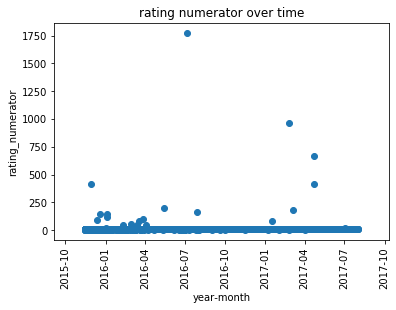

In [68]:
plt.scatter(master.timestamp, master.rating_numerator)
plt.xlabel('year-month')
plt.ylabel('rating_numerator')
plt.title('rating numerator over time')
plt.xticks(rotation=90)
plt.show()

Looks like in rare cases the rating given is much higher than the majority of the ratings. Let's have a closer look at both the rating_numerator and rating_denominator. 

In [69]:
master.rating_numerator.value_counts()

12.00      558
11.00      464
10.00      461
13.00      351
9.00       159
8.00       102
7.00        55
14.00       54
5.00        35
6.00        32
3.00        19
4.00        17
2.00         9
1.00         8
0.00         2
420.00       2
9.75         2
15.00        2
960.00       1
84.00        1
17.00        1
13.50        1
143.00       1
50.00        1
121.00       1
182.00       1
165.00       1
45.00        1
204.00       1
1776.00      1
666.00       1
99.00        1
11.27        1
11.26        1
88.00        1
144.00       1
9.50         1
20.00        1
44.00        1
60.00        1
80.00        1
Name: rating_numerator, dtype: int64

In [70]:
(master.rating_numerator <= 15).sum() / len(master)

0.9906621392190152

The vast majority (> 99%) of rating_numerators are between 0 and 15. 

In [71]:
master.rating_denominator.value_counts()

10.0     2334
50.0        3
11.0        3
80.0        2
20.0        2
150.0       1
110.0       1
90.0        1
130.0       1
70.0        1
170.0       1
120.0       1
16.0        1
40.0        1
15.0        1
0.0         1
Name: rating_denominator, dtype: int64

In [72]:
(master.rating_denominator == 10).sum() / len(master)

0.9906621392190152

The vast majority (> 99%) of rating_denominators are equal to 10. 

---

Moving forward I will only analyze tweets with a rating_numerator equal to or smaller than 15 and a rating_denominator equal to 10. 

In [73]:
# apply the filters
m_filt = master[((master.rating_numerator <= 15) & (master.rating_denominator == 10))]
# check the dimensions of this new dataset
m_filt.shape

(2328, 15)

Let's have a look again how rating changed over time.

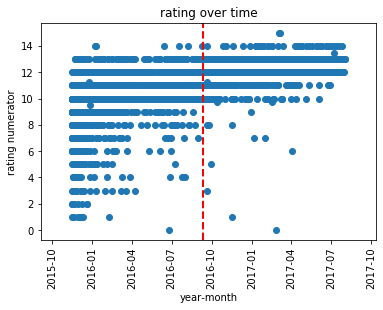

In [74]:
plt.figure(figsize=(6,4))

plt.scatter(m_filt.timestamp, m_filt.rating_numerator)
plt.xlabel('year-month')
plt.ylabel('rating numerator')
plt.title('rating over time')
plt.xticks(rotation=90)
plt.axvline(pd.to_datetime('2016-09-12'), color='r', linestyle='--', lw=2)
plt.savefig('rating_over_time.png', bbox_inches='tight')
plt.show()

In [81]:
# calculate mean and standard deviation of dog ratings before and after the 'They're Good Dogs Brent' tweet
before_mean = m_filt.rating_numerator[m_filt.timestamp <= '2016-09-12'].mean()
before_std = m_filt.rating_numerator[m_filt.timestamp <= '2016-09-12'].std()
after_mean = m_filt.rating_numerator[m_filt.timestamp > '2016-09-12'].mean()
after_std = m_filt.rating_numerator[m_filt.timestamp > '2016-09-12'].std()

In [82]:
before_mean, before_std, after_mean, after_std

(10.008221649484536,
 2.1804081464727556,
 12.109884020618557,
 1.2894300264004401)

There is a clear trend towards higher ratings over time. In the beginning, ratings spread across 1 to 12 (out of 10). Over time, lower ratings disappeared. Interestingly, after the famous tweet 'They're Good Dogs Brent' posted in response to a user taking issue with the rating system (marked with a red line) ratings below 10 became very rare. The mean and standard deviation of rating_numerator before the 'They're Good Dogs Brent' tweet were 10 and 2.18, respectively. After the tweet mean and standard deviation were 12.1 and 1.29, respectively. 

Next, I want to have a look at user engagement over time. To this end let's change the index of the dataframe to timestamps so that we can use pandas' resample() function. I will then determine the number of tweets posted per month and the median number of favorite tweets per month and create plots for both statistics. 

In [77]:
m_filt.index = m_filt.timestamp

In [78]:
m_filt_count = m_filt.resample('1M').count()
m_filt_median = m_filt.resample('1M').median()

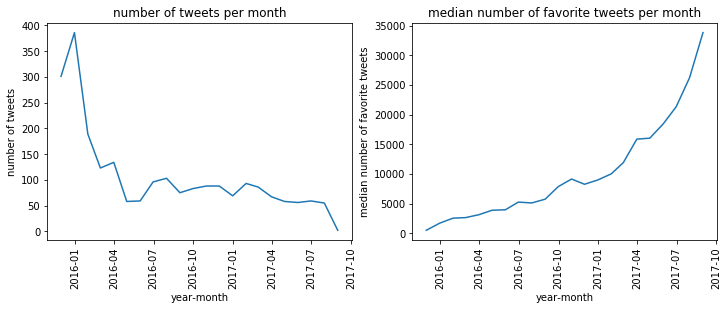

In [79]:
# create plot these two metrics
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(m_filt_count.tweet_id)
plt.title('number of tweets per month')
plt.xlabel('year-month')
plt.ylabel('number of tweets')
plt.xticks(rotation=90)

plt.subplot(122)
plt.plot(m_filt_median.favorite_count)
plt.title('median number of favorite tweets per month')
plt.xlabel('year-month')
plt.ylabel('median number of favorite tweets')
plt.xticks(rotation=90)

plt.savefig('engagement_over_time.png', bbox_inches='tight')

plt.show()

In [80]:
m_filt_count.tweet_id

timestamp
2015-11-30 00:00:00+00:00    301
2015-12-31 00:00:00+00:00    386
2016-01-31 00:00:00+00:00    189
2016-02-29 00:00:00+00:00    123
2016-03-31 00:00:00+00:00    134
2016-04-30 00:00:00+00:00     58
2016-05-31 00:00:00+00:00     59
2016-06-30 00:00:00+00:00     96
2016-07-31 00:00:00+00:00    103
2016-08-31 00:00:00+00:00     75
2016-09-30 00:00:00+00:00     83
2016-10-31 00:00:00+00:00     88
2016-11-30 00:00:00+00:00     88
2016-12-31 00:00:00+00:00     69
2017-01-31 00:00:00+00:00     93
2017-02-28 00:00:00+00:00     86
2017-03-31 00:00:00+00:00     67
2017-04-30 00:00:00+00:00     58
2017-05-31 00:00:00+00:00     56
2017-06-30 00:00:00+00:00     59
2017-07-31 00:00:00+00:00     55
2017-08-31 00:00:00+00:00      2
Freq: M, Name: tweet_id, dtype: int64

It looks like number of tweets posted per month have dropped from close to 400 in December 2015 to around 80 a few months later. After that it stabilized at around 80 tweets per month. Disregard the first and last datapoints as these came from ony partial months. 

In contrast the median number of tweet tagged as favorite steadily increased over time.